<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Viterbi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Objective: Create segments that contains bouts of calling

In [2]:
import librosa
import os
from librosa import display
import scipy
import numpy as np
from matplotlib import pyplot as plt
import math
from librosa.core.convert import samples_like
from scipy import fftpack, signal
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Step 1: Calculate the probability of call state given amplitude
Original code can be found in the notebook Minimum_threshold.ipynb

In [6]:
def filt(samples, sampling_rate=44100, low_thresh=350, upp_thresh=5000): 
  yf = rfft(samples)
  xf = rfftfreq(len(samples), 1 / sampling_rate)
  points_per_freq = len(xf) / (sampling_rate / 2)

  target_idx_noise_lower = int(points_per_freq * low_thresh)
  target_idx_noise_upper = int(points_per_freq * upp_thresh)
  yf[: target_idx_noise_lower] = 0
  yf[target_idx_noise_upper:] = 0
  filt_signal = irfft(yf)
  return filt_signal

def z_score(data,average,std):
  error = math.exp(-10000)
  z = (data-average)/(std+error)
  return z

def logistic_function(x,threshold,std):
  probability = 1/(1+math.exp(-(x-threshold)))
  return probability
 
def state_probability(file_path):
  file_name = os.path.basename(file_path)
  sampling_rate = 44100
  samples, sampling_rate = librosa.load(file_path,sr=sampling_rate)

  filtered_sig = filt(samples)

  hilbert_signal = abs(scipy.signal.hilbert(filtered_sig))
  #hilbert_signal = scipy.ndimage.filters.gaussian_filter1d(hilbert_signal,sigma=5)

  #get statistics for the amplitudes
  mean_amplitude = np.mean(hilbert_signal)
  stdev = np.std(hilbert_signal)

  normalized_signal = z_score(hilbert_signal,mean_amplitude,stdev)

  std_normalized = np.std(normalized_signal)

  vectorized_logistics = np.vectorize(logistic_function)

  #data points with z_score>3 categorized into yes call state
  probability_each_point = vectorized_logistics(normalized_signal,3,std_normalized)

  return probability_each_point

#####testing to ensure the function works

In [4]:
file_path='/content/drive/MyDrive/Xenopus_male_female_data/overall_copy/laevis/F818D-F8387/duets/chunks/rapping/01-F818D-F8387-220615_1834_1'

In [8]:
sampling_rate = 44100
samples,sr = librosa.load(file_path,sr=sampling_rate)

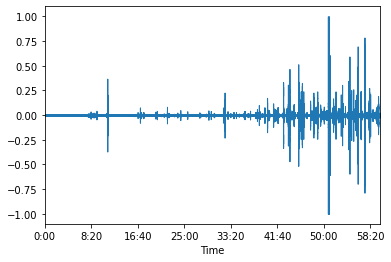

In [9]:
display.waveplot(samples,sr=sampling_rate,x_axis='time')
plt.show()

In [10]:
probability_each_point = state_probability(file_path)

In [11]:
#time vector
duration = len(samples)/sampling_rate
x_time = np.arange(0,duration,1/sampling_rate)

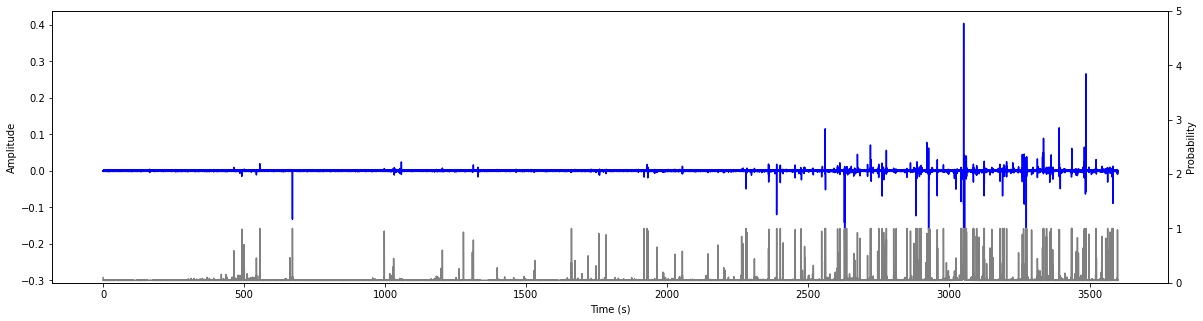

In [13]:
#plot true signal and probability likelihood
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)
ax1.plot(x_time[::1000],samples[::1000],color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")

ax2 = ax1.twinx()
ax2.plot(x_time[::1000],probability_each_point[::1000],color='grey')
ax2.set_ylabel("Probability")
ax2.set_ylim(0,5)

#ax2.set_xlim(510,550)
plt.show()

###Step 2: Setting the parameters and run Viterbi_discriminative

Parameter 1: prob

In [14]:
def prob_generate(probability_each_point):
  yes_call_prob = probability_each_point
  no_call_prob = [1-i for i in yes_call_prob]
  prob = np.row_stack((yes_call_prob,no_call_prob))
  return prob

In [15]:
prob = prob_generate(probability_each_point)

In [16]:
np.array(prob).shape

(2, 158760000)

Parameter 2: transition matrix (2*2)

In [17]:
#assumption that the transition between states is less likely compared to within states
yes_to_no = 0.1
no_to_yes = yes_to_no
transition_matrix = np.row_stack(([1-yes_to_no,yes_to_no],[no_to_yes,1-no_to_yes]))

In [18]:
transition_matrix

array([[0.9, 0.1],
       [0.1, 0.9]])

Parameter 3: p_init

In [19]:
yes_init = 0.1
p_init = np.array([yes_init,1-yes_init])

In [20]:
p_init

array([0.1, 0.9])

Run the viterbi_discrimative algorithm

In [21]:
states = librosa.sequence.viterbi_discriminative(prob,transition_matrix,p_init=p_init)

In [ ]:
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)
ax1.plot(x_time,samples,color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")

ax2 = ax1.twinx()
ax2.plot(x_time,states,color='grey')
ax2.set_ylim(0,5)
#ax2.set_xlim(200,203)
plt.show()